
<h1 style="font-family: 'poppins'; font-weight: bold; color: Green;">👨‍💻Author: Danish Javaid Meo</h1>

[![Email](https://img.shields.io/badge/Email-Contact%20Me-red?style=for-the-badge&logo=email)](danishjmeo@gmail.com)
[![Kaggle](https://img.shields.io/badge/Kaggle-Profile-blue?style=for-the-badge&logo=kaggle)](https://www.kaggle.com/danishjmeo)
[![GitHub](https://img.shields.io/badge/GitHub-Profile-blue?style=for-the-badge&logo=github)](https://github.com/danishmeo9) 
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/in/danish-javaid-4271a8231/)  

# Load necessary libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from numpy import log
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Generate sales data

In [25]:
np.random.seed(42)

start_date = datetime(2020, 1, 1)

num_months = 48 # 4 years of monthly data

date_rng = pd.date_range(start_date, periods=num_months, freq='MS') # MS for Month Start



sales_data = pd.DataFrame(date_rng, columns=['Date'])

# Base sales with a slight upward trend

base_sales = 10000 + np.arange(num_months) * 50

# Seasonal component (higher in Q4, lower in Q1)
seasonal_component = 2000 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 12 + np.pi/2) \
+ 1500 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 6)
# Random noise
noise = np.random.normal(0, 500, num_months)
sales_data['SalesAmount'] = (base_sales + seasonal_component + noise).astype(int)
sales_data['SalesAmount'] = sales_data['SalesAmount'].clip(lower=2000) # Ensure sales are positive

# Add promotional flags (randomly)
sales_data['Promotion'] = np.random.choice([0, 1], num_months, p=[0.8, 0.2])

sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'] *= np.random.uniform(1.1, 1.3) # Increase sales during promotion

# Add holiday flags (e.g., December)

sales_data['HolidayMonth'] = (sales_data['Date'].dt.month == 12).astype(int)

sales_data.loc[sales_data['HolidayMonth'] == 1, 'SalesAmount'] *= np.random.uniform(1.15, 1.4) # Increase sales during holiday month


sales_data['SalesAmount'] = sales_data['SalesAmount'].astype(int)


C:\Users\dell\AppData\Local\Temp\ipykernel_5640\2920725166.py:28: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[14030.88621694  9131.45660586 13786.55770615 10279.80060657
 16623.34031037 12949.41107182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



# How data Looks Like?

In [26]:
sales_data.head()

,Date,SalesAmount,Promotion,HolidayMonth
0,2020-01-01,12248,0,0
1,2020-02-01,13011,0,0
2,2020-03-01,12722,0,0
3,2020-04-01,14030,1,0
4,2020-05-01,7783,0,0


In [27]:
print(f"The Shape of the Dataset: {sales_data.shape}")

The Shape of the Dataset: (48, 4)


In [28]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          48 non-null     datetime64[ns]
 1   SalesAmount   48 non-null     int64         
 2   Promotion     48 non-null     int64         
 3   HolidayMonth  48 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.6 KB


# Missing values 

In [29]:
sales_data.isnull().sum()

Date            0
SalesAmount     0
Promotion       0
HolidayMonth    0
dtype: int64

count       48.000000
mean     11768.541667
std       2257.544863
min       7783.000000
25%      10219.750000
50%      11851.000000
75%      13014.000000
max      17996.000000
Name: SalesAmount, dtype: float64


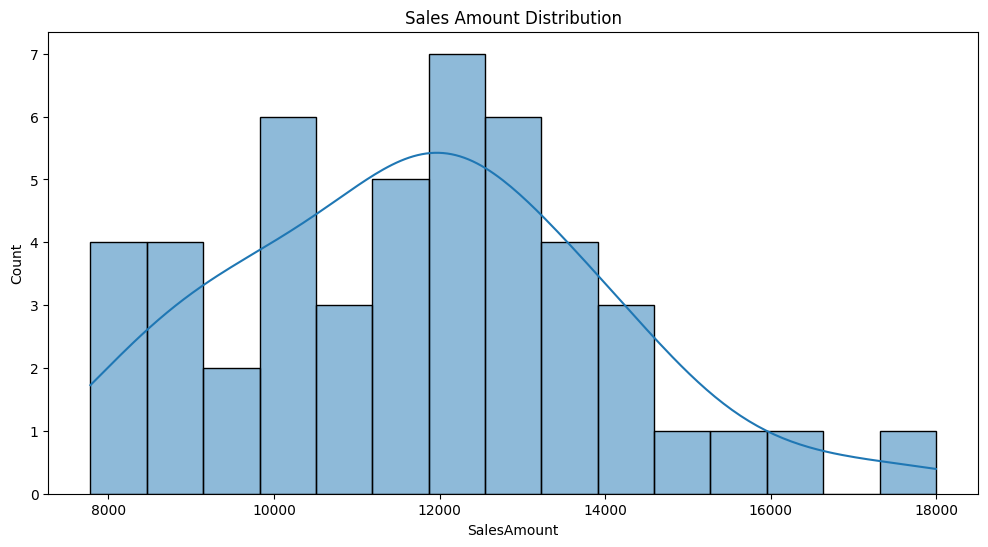

In [30]:
# print("📊 Statistical Summary:")
print(sales_data['SalesAmount'].describe())
plt.figure(figsize=(12, 6))
sns.histplot(sales_data['SalesAmount'], kde=True, bins=15)
plt.title('Sales Amount Distribution')
plt.show()

# Let' see Amount of sales in moths where holiday is present

In [31]:

sales_data['Year'] = sales_data['Date'].dt.year
sales_data['Month'] = sales_data['Date'].dt.month_name()

# Filter rows where HolidayMonth == 1
holiday_sales = sales_data[sales_data['HolidayMonth'] == 1][['Date', 'Month', 'SalesAmount']]
# Display result
print("Sales Amount of Months Having Holidays:")
print(holiday_sales)


Sales Amount of Months Having Holidays:
         Date     Month  SalesAmount
11 2020-12-01  December        14534
23 2021-12-01  December        14696
35 2022-12-01  December        15645
47 2023-12-01  December        17996


# Let's see the each years highest and lowest month accoding to salesAmount

In [32]:

# Find highest sales month for each year
highest_sales = sales_data.loc[sales_data.groupby('Year')['SalesAmount'].idxmax()]

# Find lowest sales month for each year
lowest_sales = sales_data.loc[sales_data.groupby('Year')['SalesAmount'].idxmin()]

# Display results
print("Highest Sales Month for Each Year:")
print(highest_sales[['Year', 'Month', 'SalesAmount']])

print("\nLowest Sales Month for Each Year:")
print(lowest_sales[['Year', 'Month', 'SalesAmount']])

Highest Sales Month for Each Year:
    Year     Month  SalesAmount
11  2020  December        14534
23  2021  December        14696
24  2022   January        16623
47  2023  December        17996

Lowest Sales Month for Each Year:
    Year Month  SalesAmount
4   2020   May         7783
17  2021  June         7976
29  2022  June         8273
41  2023  June         9104


# Growth Rate 

In [33]:
# Extract year from the Date column
sales_data['Year'] = sales_data['Date'].dt.year

# Group by year and sum sales
annual_sales = sales_data.groupby('Year')['SalesAmount'].sum().reset_index()

# Calculate YoY growth
annual_sales['YoY_Growth_Rate'] = annual_sales['SalesAmount'].pct_change() * 100

# Round to 2 decimal places
annual_sales['YoY_Growth_Rate'] = annual_sales['YoY_Growth_Rate'].round(2)

# Display result
print(annual_sales)


   Year  SalesAmount  YoY_Growth_Rate
0  2020       137067              NaN
1  2021       133056            -2.93
2  2022       144304             8.45
3  2023       150463             4.27


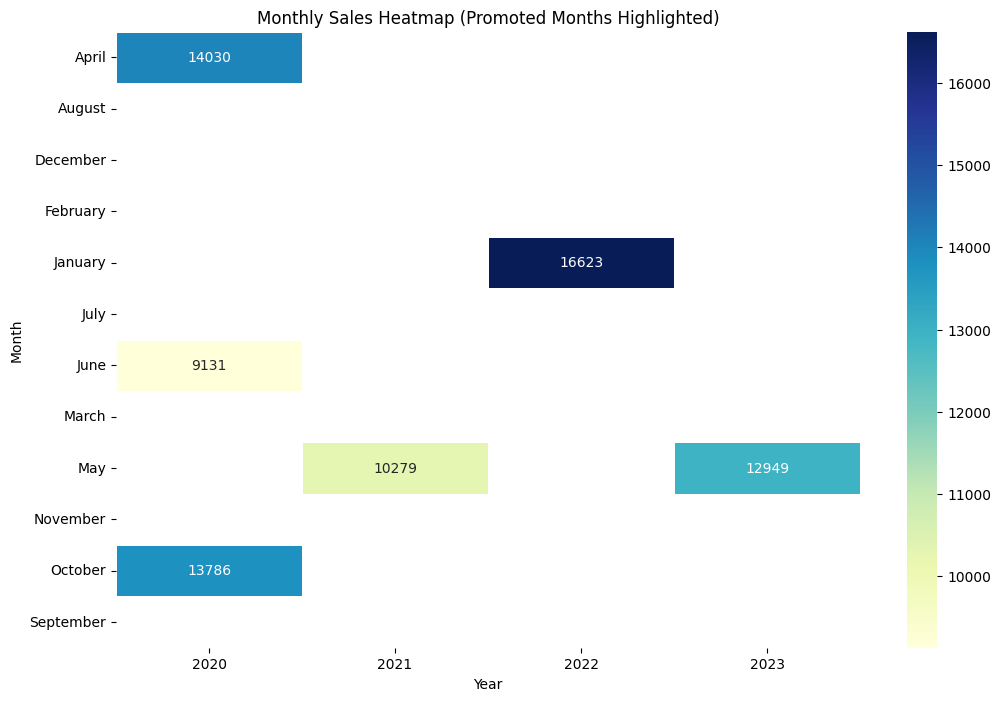

In [34]:
# Heatmap of sales by month and year (with promotions)
heatmap_data = sales_data.pivot_table(index='Month', columns='Year', values='SalesAmount', aggfunc='mean')
promo_data = sales_data.pivot_table(index='Month', columns='Year', values='Promotion', aggfunc='max')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", 
            mask=promo_data==0, linewidths=0.5)
plt.title("Monthly Sales Heatmap (Promoted Months Highlighted)")
plt.show()

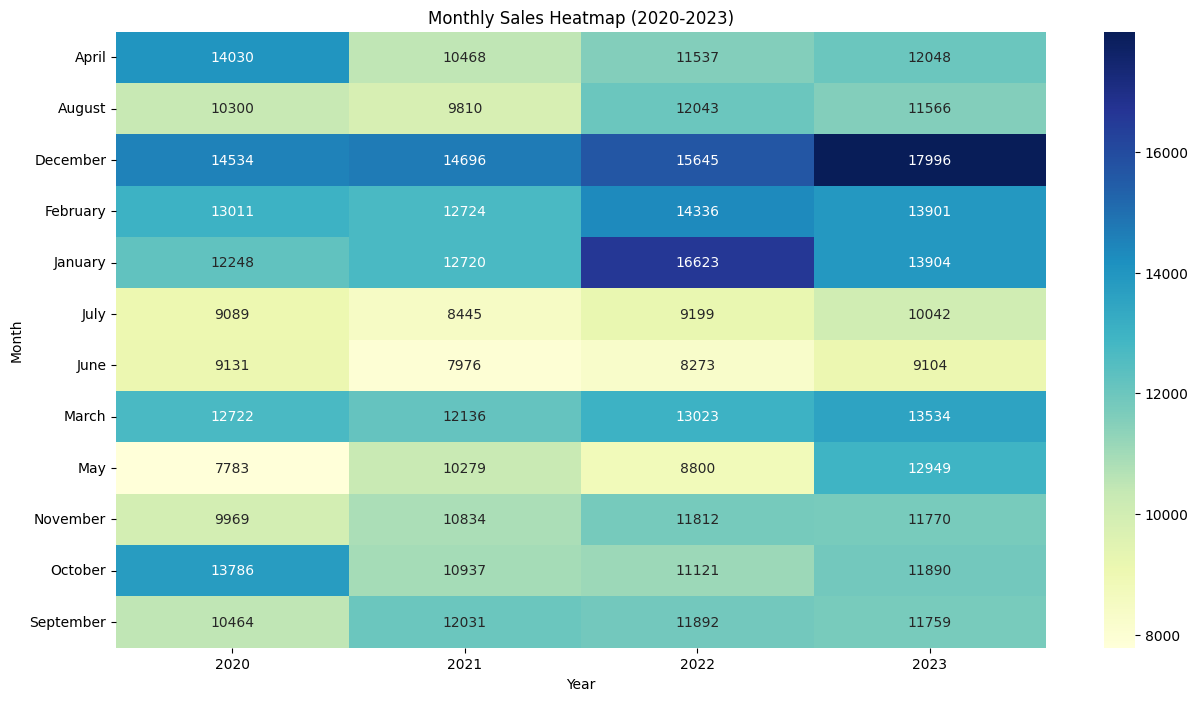

In [35]:
# Interactive Calendar Heatmap
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
sales_data['Year'] = sales_data['Date'].dt.year
sales_data['Month'] = sales_data['Date'].dt.month_name()

heatmap_data = sales_data.pivot_table(index='Month', columns='Year', values='SalesAmount')
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Monthly Sales Heatmap (2020-2023)")
plt.show()

<Axes: xlabel='Date', ylabel='SalesAmount'>

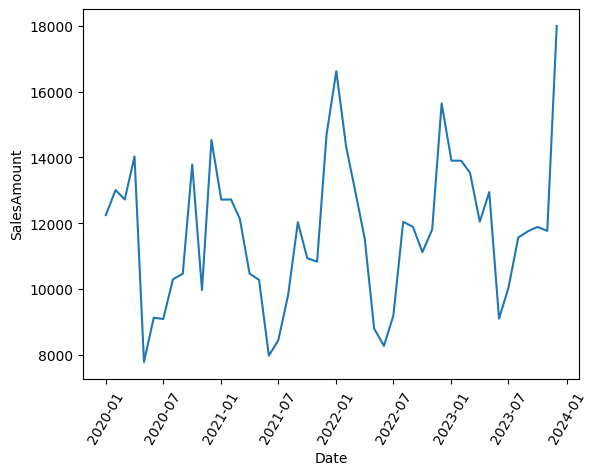

In [36]:
plt.xticks(rotation = 60)
sns.lineplot(x='Date', y='SalesAmount', data=sales_data)

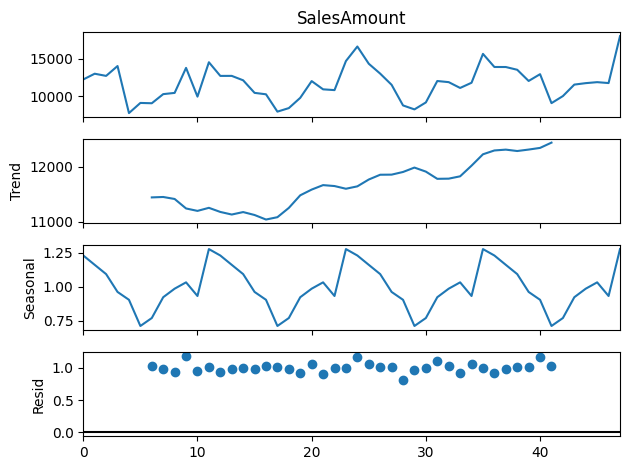

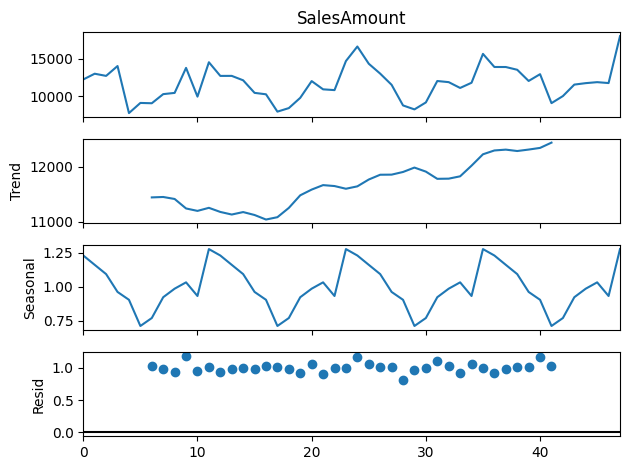

In [37]:
# decompose the data into trend, seasonality and residuals
decompose = seasonal_decompose(sales_data["SalesAmount"], model="multiplicative", period=12)
decompose.plot()

In [38]:
# Plotly Interactive Version
fig = px.line(
    sales_data, 
    x="Date", 
    y="SalesAmount",
    title='<b>Sales Performance Over Time (2020-2023)</b>',
    labels={'SalesAmount': 'Sales Amount'},
    markers=True
)
# change color of line
fig.update_traces(line_color='red')

fig.show()

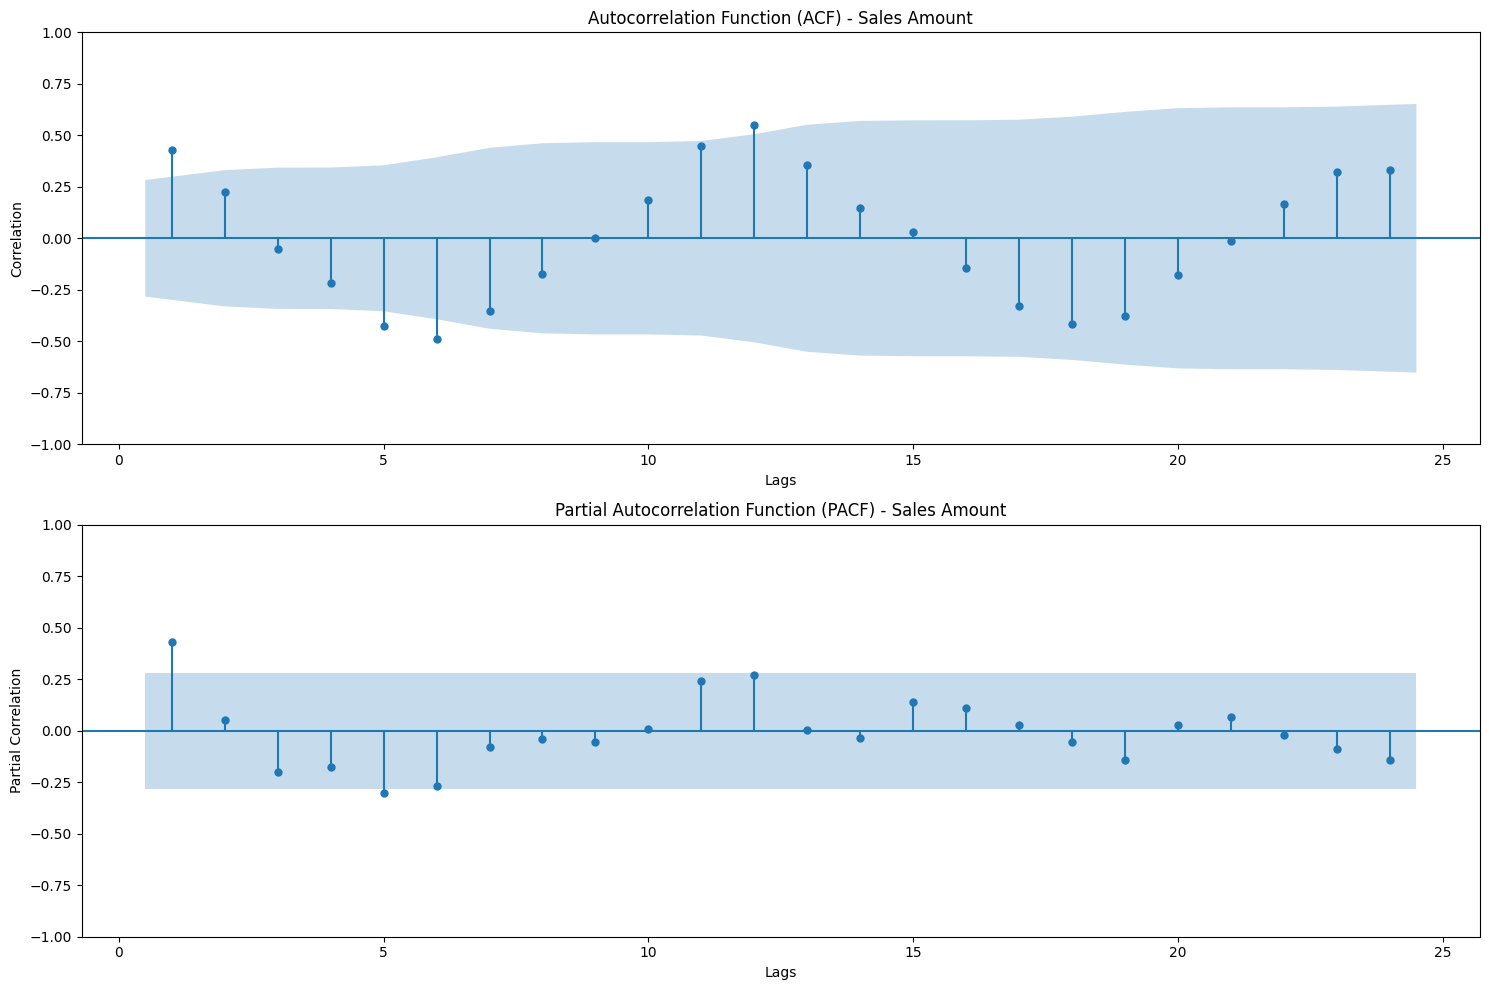

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# ACF Plot
plot_acf(sales_data['SalesAmount'], 
         lags=24,  # 2 years of monthly lags
         alpha=0.05,  # 95% confidence interval
         title='Autocorrelation Function (ACF) - Sales Amount',
         ax=ax1,
         zero=False)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation')

# PACF Plot
plot_pacf(sales_data['SalesAmount'],
          lags=24,
          alpha=0.05,
          title='Partial Autocorrelation Function (PACF) - Sales Amount',
          ax=ax2,
          zero=False,
          method='ywm')  # ywm = yule-walker with bias correction
ax2.set_xlabel('Lags')
ax2.set_ylabel('Partial Correlation')

plt.tight_layout()
plt.show()

# ADF Test

In [40]:
# Perform ADF Test on sales data
adf_result = adfuller(sales_data['SalesAmount'], regression='c')  # 'c' = constant only (no trend)

# Extract and format results
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print(f"""
📉 ADF Test Results for Sales Data:
------------------------------------
| Hypothesis Testing               |
|-----------------------------------|
| Null Hypothesis (H0):            | Time series is non-stationary  |
| Alternative Hypothesis (H1):     | Time series is stationary      |
| Significance Level (α):          | 0.05                           |

| Test Statistics                  |
|-----------------------------------|
| ADF Statistic:                   | {adf_statistic:.4f}           |
| p-value:                         | {p_value:.4f}                 |

| Critical Values                  |
|-----------------------------------|

| 5% confidence level:             | {critical_values['5%']:.4f}   |


| Conclusion                       |
|-----------------------------------|
{"Non-Stationary Series (fail to reject H0)" if p_value > 0.05 else "Stationary Series (we reject H0)"}
""")


📉 ADF Test Results for Sales Data:
------------------------------------
| Hypothesis Testing               |
|-----------------------------------|
| Null Hypothesis (H0):            | Time series is non-stationary  |
| Alternative Hypothesis (H1):     | Time series is stationary      |
| Significance Level (α):          | 0.05                           |

| Test Statistics                  |
|-----------------------------------|
| ADF Statistic:                   | -4.5142           |
| p-value:                         | 0.0002                 |

| Critical Values                  |
|-----------------------------------|

| 5% confidence level:             | -2.9333   |


| Conclusion                       |
|-----------------------------------|
Stationary Series (we reject H0)



# ARIMA MODEL

Forecast: 48    14860.048001
49    13333.715023
50    12560.960479
51    12169.728949
52    11971.655562
Name: predicted_mean, dtype: float64


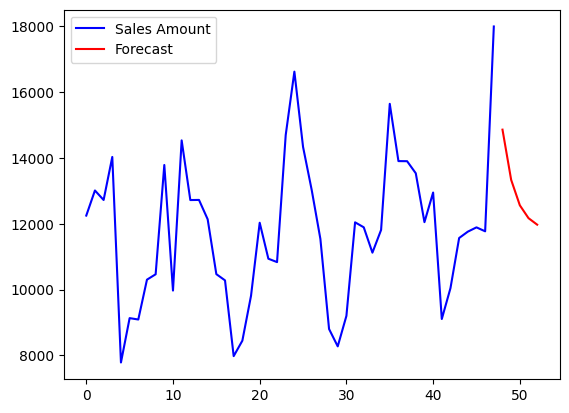

In [41]:
# Build ARIMA model (p=1, d=0, q=1)
model = ARIMA(sales_data['SalesAmount'], order=(1,0,1))
model_fit = model.fit()

# Forecast next 5 points
forecast = model_fit.forecast(steps=5)

print("Forecast:", forecast)

# Plot original data and forecast
plt.plot(sales_data['SalesAmount'], label='Sales Amount', color='blue')
plt.plot(range(len(sales_data['SalesAmount']), len(sales_data['SalesAmount'])+5), forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# SARIMAX

c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



SARIMA Forecast: 48    15203.453678
49    14610.026805
50    13982.442325
51    12478.810026
52    12416.348811
Name: predicted_mean, dtype: float64


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



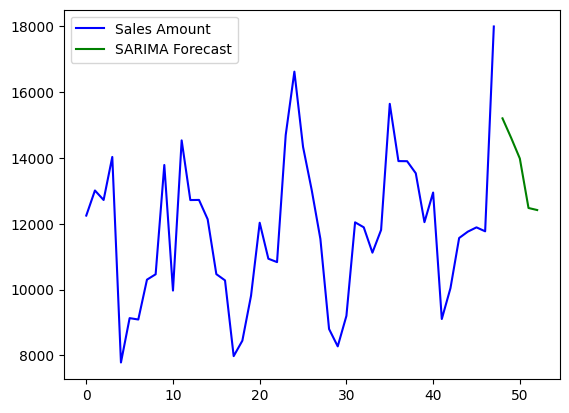

In [42]:

sarima_model = SARIMAX(sales_data['SalesAmount'], order=(1,0,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()

# Forecast next 5 points
sarima_forecast = sarima_fit.forecast(steps=5)

print("SARIMA Forecast:", sarima_forecast)

# Plot original data and forecast
plt.plot(sales_data['SalesAmount'], label='Sales Amount', color='blue')
plt.plot(range(len(sales_data['SalesAmount']), len(sales_data['SalesAmount'])+5), sarima_forecast, label='SARIMA Forecast', color='green')
plt.legend()
plt.show()


Tuning SARIMA parameters...
Best SARIMA order: (1, 1, 0), seasonal_order: (1, 1, 0, 12), AIC: 520.4962656530209
Validation MAE: 934.172
Validation RMSE: 1042.480
Validation MAPE: 7.33%

Next 6 months forecast:
48    17545.098557
49    16525.071237
50    15658.113135
51    14178.447035
52    13262.562816
53    11073.647716
Name: predicted_mean, dtype: float64


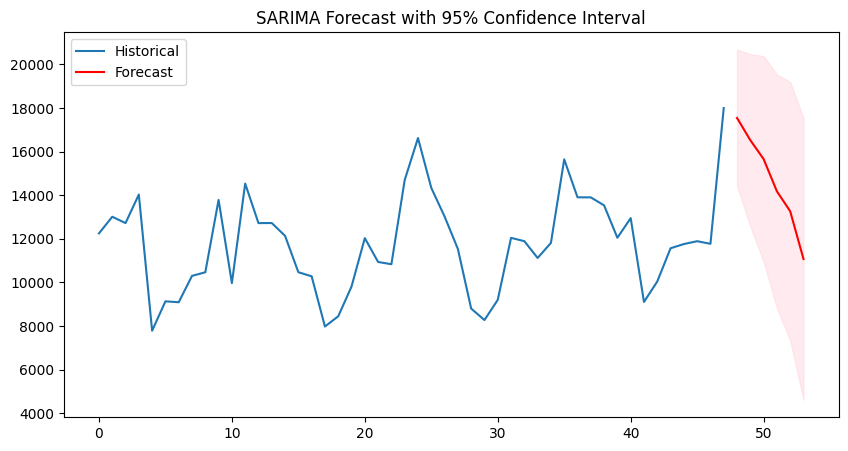

In [46]:
import warnings
warnings.filterwarnings('ignore')

# === Metrics ===
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# === Load your data ===
# sales_data = pd.read_csv('your_file.csv', parse_dates=['Date'], index_col='Date')  # Example

# Assume sales_data['SalesAmount'] is ready and indexed by datetime

# Split data into train and validation (last 6 months for validation)
train = sales_data['SalesAmount'][:-6]
valid = sales_data['SalesAmount'][-6:]

# Define parameter ranges for SARIMA tuning
p = d = q = range(0, 2)  # 0 or 1
P = D = Q = range(0, 2)
s = 12  # monthly seasonality

best_aic = np.inf
best_params = None
best_model = None

print("Tuning SARIMA parameters...")

for order in [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]:
    for seasonal_order in [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]:
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = (order, seasonal_order)
                best_model = model_fit
        except:
            continue

print(f"Best SARIMA order: {best_params[0]}, seasonal_order: {best_params[1]}, AIC: {best_aic}")

# Forecast on validation set (6 months)
forecast_valid = best_model.forecast(steps=6)

# Evaluate
mae = mean_absolute_error(valid, forecast_valid)
mse = mean_squared_error(valid, forecast_valid)
rmse = np.sqrt(mse)
mape_val = mape(valid, forecast_valid)

print(f"Validation MAE: {mae:.3f}")
print(f"Validation RMSE: {rmse:.3f}")
print(f"Validation MAPE: {mape_val:.2f}%")

# Retrain best model on full dataset
final_model = SARIMAX(sales_data['SalesAmount'], order=best_params[0], seasonal_order=best_params[1])
final_fit = final_model.fit(disp=False)

# Forecast next 6 months with confidence intervals
forecast_res = final_fit.get_forecast(steps=6)
forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

print("\nNext 6 months forecast:")
print(forecast)

# Plot
plt.figure(figsize=(10,5))
plt.plot(sales_data['SalesAmount'], label='Historical')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast with 95% Confidence Interval")
plt.show()


In [44]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        SalesAmount   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -257.065
Date:                            Fri, 23 May 2025   AIC                            524.130
Time:                                    22:56:49   BIC                            530.966
Sample:                                         0   HQIC                           526.271
                                             - 42                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0429      0.934     -0.046      0.963      -1.874       1.789
ma.L1         -0.1762      0.971   

In [45]:
# Prepare forecast DataFrame to save
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
})

# Save to CSV
forecast_df.to_csv('sales_forecast_6months.csv', index=True)

print("Forecast saved to sales_forecast_6months_final.csv")


Forecast saved to sales_forecast_6months_final.csv



##  **Observations**
The dataset contains synthetic monthly sales data spanning from January 2020 to December 2023. It includes columns for Date, SalesAmount, Promotion, and HolidayMonth. SalesAmount is influenced by a base upward trend, seasonal effects, promotional activity, and holiday impact, particularly in December. The data shows an average sales value of approximately 11,769 with a standard deviation of about 2,258. Minimum and maximum sales range from 7,783 to 17,996, with the middle 50% falling between 10,220 and 13,014. Holiday months consistently show the highest sales, especially December, with peak values such as 14,534 in December 2020, 14,696 in December 2021, 16,623 in January 2022, and 17,996 in December 2023. The lowest sales typically occur in June across multiple years. Annual growth analysis reveals a slight decline of -2.93% in 2021, followed by strong growth of 8.45% in 2022, and a continued increase of 4.27% in 2023. Diagnostic tests indicate that the time series model fits well, with no significant autocorrelation (p=0.32), normally distributed residuals (p=0.44), and constant variance (p=0.34).

## `Recommendations`
Based on the sales trends and analysis, it is recommended to focus marketing efforts during the months of December and other holiday periods, as these consistently show the highest sales volumes. Promotions should be strategically aligned with seasonal peaks to maximize impact, especially in Q4. June has repeatedly shown the lowest sales, suggesting an opportunity for targeted promotional campaigns or new product launches to boost activity during this slower period. Additionally, due to the overall upward trend in sales and strong growth in recent years, inventory planning should accommodate higher demand toward year-end. While the time series model fits well . Monitoring external factors that might influence seasonal shifts can also enhance decision-making and long-term planning.

----
